<a href="https://colab.research.google.com/github/WilliamZhang20/AI-Moonlander/blob/master/PPO_Moonlander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!sudo apt-get install -y build-essential swig libopenmpi-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libopenmpi-dev is already the newest version (4.1.2-2ubuntu1).
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 85.9 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2351186 sha256=efca83fdd37d8b411173e134d470cff6bc73ee49da8f369b2a8106639e666cce
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import random

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(ActorCritic, self).__init__()

        # Shared feature extractor
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Actor head (policy network)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

        # Critic head (value network)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state):
        shared_features = self.shared(state)
        action_logits = self.actor(shared_features)
        state_value = self.critic(shared_features)
        return action_logits, state_value

    def get_action_and_value(self, state, action=None):
        action_logits, state_value = self.forward(state)
        probs = Categorical(logits=action_logits)

        if action is None:
            action = probs.sample()

        return action, probs.log_prob(action), probs.entropy(), state_value.squeeze()

Now a memory buffer leveraging Generalized Advantage Estimation (GAE).

In [12]:

class PPOBuffer:
    def __init__(self, size, state_dim, gamma=0.99, lam=0.95):
        self.size = size
        self.gamma = gamma
        self.lam = lam

        self.states = np.zeros((size, state_dim), dtype=np.float32)
        self.actions = np.zeros(size, dtype=np.int32)
        self.rewards = np.zeros(size, dtype=np.float32)
        self.values = np.zeros(size, dtype=np.float32)
        self.log_probs = np.zeros(size, dtype=np.float32)
        self.dones = np.zeros(size, dtype=np.bool_)

        self.ptr = 0
        self.path_start_idx = 0

    def store(self, state, action, reward, value, log_prob, done):
        assert self.ptr < self.size
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.values[self.ptr] = value
        self.log_probs[self.ptr] = log_prob
        self.dones[self.ptr] = done
        self.ptr += 1

    def finish_path(self, last_val=0):
        path_slice = slice(self.path_start_idx, self.ptr)
        rewards = np.append(self.rewards[path_slice], last_val)
        values = np.append(self.values[path_slice], last_val)

        # Compute GAE advantages
        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]
        advantages = self._discount_cumsum(deltas, self.gamma * self.lam)

        # Compute returns (targets for value function)
        returns = advantages + self.values[path_slice]

        self.advantages = advantages if not hasattr(self, 'advantages') else np.append(self.advantages, advantages)
        self.returns = returns if not hasattr(self, 'returns') else np.append(self.returns, returns)

        self.path_start_idx = self.ptr

    def get(self):
        assert self.ptr == self.size

        # Normalize advantages
        adv_mean = np.mean(self.advantages)
        adv_std = np.std(self.advantages)
        self.advantages = (self.advantages - adv_mean) / (adv_std + 1e-8)

        data = dict(
            states=torch.FloatTensor(self.states),
            actions=torch.LongTensor(self.actions),
            advantages=torch.FloatTensor(self.advantages),
            returns=torch.FloatTensor(self.returns),
            log_probs=torch.FloatTensor(self.log_probs)
        )

        # Reset buffer
        self.ptr = 0
        self.path_start_idx = 0
        delattr(self, 'advantages')
        delattr(self, 'returns')

        return data

    def _discount_cumsum(self, x, discount):
        return np.array([np.sum(discount**np.arange(len(x)-i) * x[i:]) for i in range(len(x))])

Below is the PPO Model implementation, combining the Actor-Critic neural network and the memory buffer.

In [15]:
class PPO:
    def __init__(self, env_name="LunarLander-v3", lr=3e-4, gamma=0.99, lam=0.95,
                 clip_epsilon=0.2, entropy_coef=0.01, value_coef=0.5,
                 steps_per_epoch=4000, epochs=10, minibatch_size=64, hidden_dim=256):

        self.env = gym.make(env_name)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n

        # Hyperparameters
        self.lr = lr
        self.gamma = gamma
        self.lam = lam
        self.clip_epsilon = clip_epsilon
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.minibatch_size = minibatch_size

        # Networks and optimizer
        self.actor_critic = ActorCritic(self.state_dim, self.action_dim, hidden_dim)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)

        # Buffer
        self.buffer = PPOBuffer(steps_per_epoch, self.state_dim, gamma, lam)

        # Tracking
        self.episode_rewards = deque(maxlen=100)
        self.episode_lengths = deque(maxlen=100)

    def collect_experience(self):
        state, _ = self.env.reset()
        episode_reward = 0
        episode_length = 0

        for step in range(self.steps_per_epoch):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            with torch.no_grad():
                action, log_prob, _, value = self.actor_critic.get_action_and_value(state_tensor)

            action_np = action.cpu().numpy()[0]
            next_state, reward, terminated, truncated, _ = self.env.step(action_np)
            done = terminated or truncated

            self.buffer.store(state, action_np, reward, value.item(), log_prob.item(), done)

            state = next_state
            episode_reward += reward
            episode_length += 1

            if done:
                self.buffer.finish_path()
                self.episode_rewards.append(episode_reward)
                self.episode_lengths.append(episode_length)

                state, _ = self.env.reset()
                episode_reward = 0
                episode_length = 0

        # Handle last trajectory if not finished
        if not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                _, _, _, last_val = self.actor_critic.get_action_and_value(state_tensor)
            self.buffer.finish_path(last_val.item())

    def update_policy(self):
        data = self.buffer.get()

        # Convert to tensors
        states = data['states']
        actions = data['actions']
        advantages = data['advantages']
        returns = data['returns']
        old_log_probs = data['log_probs']

        # Training loop
        dataset_size = states.shape[0]
        total_loss = 0
        policy_loss_total = 0
        value_loss_total = 0
        entropy_loss_total = 0

        for epoch in range(self.epochs):
            # Shuffle data
            indices = torch.randperm(dataset_size)

            for start_idx in range(0, dataset_size, self.minibatch_size):
                end_idx = min(start_idx + self.minibatch_size, dataset_size)
                batch_indices = indices[start_idx:end_idx]

                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]

                # Forward pass
                _, new_log_probs, entropy, values = self.actor_critic.get_action_and_value(
                    batch_states, batch_actions
                )

                # Policy loss (PPO clipped objective)
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                # Value loss
                value_loss = F.mse_loss(values, batch_returns)

                # Entropy loss (for exploration)
                entropy_loss = -entropy.mean()

                # Total loss
                loss = policy_loss + self.value_coef * value_loss + self.entropy_coef * entropy_loss

                # Backprop
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.actor_critic.parameters(), 0.5)
                self.optimizer.step()

                total_loss += loss.item()
                policy_loss_total += policy_loss.item()
                value_loss_total += value_loss.item()
                entropy_loss_total += entropy_loss.item()

        num_updates = self.epochs * (dataset_size // self.minibatch_size)
        return {
            'total_loss': total_loss / num_updates,
            'policy_loss': policy_loss_total / num_updates,
            'value_loss': value_loss_total / num_updates,
            'entropy_loss': entropy_loss_total / num_updates
        }

    def train(self, total_timesteps=200_000):
        timesteps = 0
        iteration = 0

        print("Starting PPO training...")
        print(f"Environment: {self.env.spec.id}")
        print(f"State dim: {self.state_dim}, Action dim: {self.action_dim}")
        print(f"Steps per epoch: {self.steps_per_epoch}")
        print("-" * 50)

        while timesteps < total_timesteps:
            # Collect experience
            self.collect_experience()
            timesteps += self.steps_per_epoch

            # Update policy
            losses = self.update_policy()

            iteration += 1

            # Logging
            if len(self.episode_rewards) > 0:
                avg_reward = np.mean(self.episode_rewards)
                avg_length = np.mean(self.episode_lengths)

                print(f"Iteration {iteration:4d} | "
                      f"Timesteps: {timesteps:7d} | "
                      f"Avg Reward: {avg_reward:7.2f} | "
                      f"Avg Length: {avg_length:6.1f} | "
                      f"Episodes: {len(self.episode_rewards):3d}")

                if iteration % 10 == 0:
                    print(f"  Losses - Total: {losses['total_loss']:.4f}, "
                          f"Policy: {losses['policy_loss']:.4f}, "
                          f"Value: {losses['value_loss']:.4f}, "
                          f"Entropy: {losses['entropy_loss']:.4f}")

        print("\nTraining completed!")
        return self.episode_rewards

    def test(self, num_episodes=10, render=False):
        test_rewards = []

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False

            while not done:
                if render:
                    self.env.render()

                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    action, _, _, _ = self.actor_critic.get_action_and_value(state_tensor)

                state, reward, terminated, truncated, _ = self.env.step(action.item())
                episode_reward += reward
                done = terminated or truncated

            test_rewards.append(episode_reward)
            print(f"Test Episode {episode + 1}: Reward = {episode_reward:.2f}")

        avg_reward = np.mean(test_rewards)
        print(f"\nAverage Test Reward: {avg_reward:.2f} ± {np.std(test_rewards):.2f}")
        return test_rewards

    def save(self, path):
        torch.save({
            'model_state_dict': self.actor_critic.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)
        print(f"Model saved to {path}")

    def load(self, path):
        checkpoint = torch.load(path)
        self.actor_critic.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Model loaded from {path}")

Starting PPO training...
Environment: LunarLander-v3
State dim: 8, Action dim: 4
Steps per epoch: 4000
--------------------------------------------------
Iteration    1 | Timesteps:    4000 | Avg Reward: -195.36 | Avg Length:   87.3 | Episodes:  45
Iteration    2 | Timesteps:    8000 | Avg Reward: -161.77 | Avg Length:   86.8 | Episodes:  91
Iteration    3 | Timesteps:   12000 | Avg Reward: -128.66 | Avg Length:   90.2 | Episodes: 100
Iteration    4 | Timesteps:   16000 | Avg Reward: -100.05 | Avg Length:   93.0 | Episodes: 100
Iteration    5 | Timesteps:   20000 | Avg Reward:  -76.99 | Avg Length:   98.8 | Episodes: 100
Iteration    6 | Timesteps:   24000 | Avg Reward:  -58.18 | Avg Length:  106.4 | Episodes: 100
Iteration    7 | Timesteps:   28000 | Avg Reward:  -45.12 | Avg Length:  126.6 | Episodes: 100
Iteration    8 | Timesteps:   32000 | Avg Reward:  -37.38 | Avg Length:  146.0 | Episodes: 100
Iteration    9 | Timesteps:   36000 | Avg Reward:  -33.56 | Avg Length:  170.2 | Episo

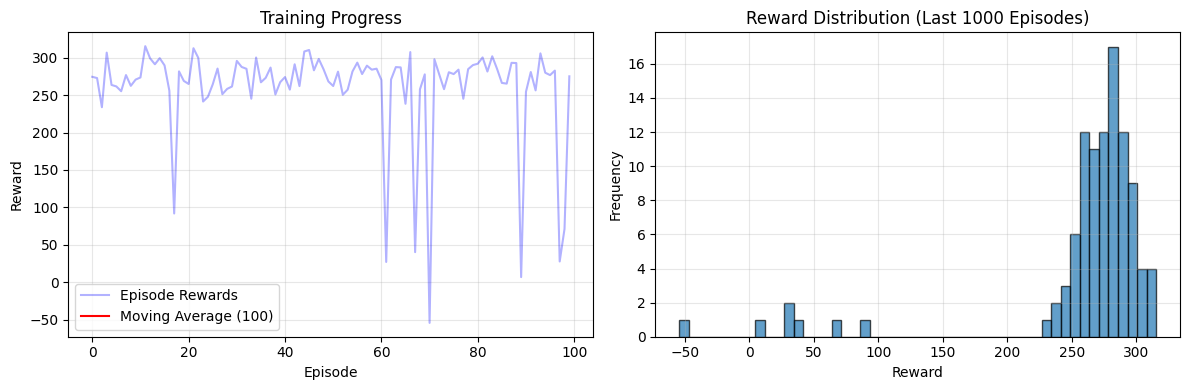

Model saved to ppo_lunarlander.pth

LunarLander is considered solved when average reward > 200
Final average reward (last 100 episodes): 260.00


In [16]:

def plot_training_results(rewards, window=100):
    """Plot training rewards with moving average"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(rewards, alpha=0.3, color='blue', label='Episode Rewards')
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(rewards)), moving_avg, color='red', label=f'Moving Average ({window})')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(rewards[-1000:], bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.title('Reward Distribution (Last 1000 Episodes)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Set seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    # Create PPO agent
    agent = PPO(
        env_name="LunarLander-v3",
        lr=3e-4,
        gamma=0.99,
        lam=0.95,
        clip_epsilon=0.2,
        entropy_coef=0.01,
        value_coef=0.5,
        steps_per_epoch=4000,
        epochs=10,
        minibatch_size=64,
        hidden_dim=256
    )

    # Train the agent
    training_rewards = agent.train(total_timesteps=300_000)

    # Test the trained agent
    print("\n" + "="*50)
    print("Testing trained agent...")
    test_rewards = agent.test(num_episodes=10)

    # Plot results
    if len(training_rewards) > 0:
        all_rewards = list(training_rewards)
        plot_training_results(all_rewards)

    # Save the trained model
    agent.save("ppo_lunarlander.pth")

    print(f"\nLunarLander is considered solved when average reward > 200")
    print(f"Final average reward (last 100 episodes): {np.mean(list(agent.episode_rewards)):.2f}")

In [17]:
import os
from gymnasium.wrappers import RecordVideo

def record_landing(agent, output_dir="ppo_lunarlander_recording", filename="landing.mp4", seed=42):
    """Record one landing episode using a trained PPO agent and save as .mp4."""
    env = gym.make(agent.env.spec.id, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=output_dir, name_prefix="ppo_landing", episode_trigger=lambda x: True)
    env.reset(seed=seed)
    state, _ = env.reset()
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action, _, _, _ = agent.actor_critic.get_action_and_value(state_tensor)
        state, _, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

    env.close()

    # Rename latest video file to desired name
    mp4_files = sorted([f for f in os.listdir(output_dir) if f.endswith(".mp4")], key=lambda f: os.path.getctime(os.path.join(output_dir, f)))
    if mp4_files:
        os.rename(os.path.join(output_dir, mp4_files[-1]), os.path.join(output_dir, filename))
        print(f"Saved landing video as: {os.path.join(output_dir, filename)}")
    else:
        print("No video recorded.")

print("\nRecording a landing episode...")
record_landing(agent, output_dir="ppo_lunarlander_recording", filename="landing.mp4")


Recording a landing episode...
Saved landing video as: ppo_lunarlander_recording/landing.mp4
